# SVM-SMO实现

[参考链接](https://www.cnblogs.com/pinard/p/6111471.html)

In [97]:
import numpy as np

np.random.seed(0)

data_src = 'svm'

x_train = np.load('./data/{}/train_data.npy'.format(data_src))
y_train = np.load('./data/{}/train_target.npy'.format(data_src))
x_test = np.load('./data/{}/test_data.npy'.format(data_src))
y_test = np.load('./data/{}/test_target.npy'.format(data_src))

class LinearSVM:
    def __init__(self, x_train, y_train, C=5.0, max_iter=100000):
        self.x_train = x_train
        self.y_train = y_train
        self.C = C
        self.alpha = np.random.randn(self.m)
        self.b = np.random.randn(1) * x_train[:, 1].std(ddof=1) + x_train[:, 1].mean()
        self.max_iter = max_iter
        self.phi = lambda x: x
        
    def K(self, xi, xj):
        return self.phi(xi) @ self.phi(xj)
        
    @property
    def x_dim(self):
        return len(self.x_train[0])
    
    @property
    def m(self):
        return self.x_train.shape[0]
    
    @property
    def w(self):
        w = np.zeros(self.x_dim)
        for i in range(self.m):
            w += self.alpha[i] * self.y_train[i] * self.x_train[i]
        return w
        
    def f(self, x):
        return x @ self.w + self.b
        
    def choose_i(self):
        # 确定 i
        ## 考虑 0 < alpha < C
        where = np.where((0 < self.alpha) & (self.alpha < self.C))
        if where[0].size != 0:
            criterion = np.abs(self.y_train[where] * self.f(self.x_train[where]) - 1)
            i_index_in_where = np.argmax(criterion)
            if criterion[i_index_in_where] != 0:
                return where[0][i_index_in_where]
        ## 考虑 alpha == 0
        where = np.where(self.alpha == 0)
        if where[0].size != 0:
            criterion = 1 - self.y_train[where] * self.f(self.x_train[where])
            i_index_in_where = np.argmax(criterion)
            if criterion[i_index_in_where] > 0:
                return where[0][i_index_in_where]
        ## 考虑 alpha == C
        where = np.where(self.alpha == self.C)
        if where[0].size != 0:
            criterion = self.y_train[where] * self.f(self.x_train[where]) - 1
            i_index_in_where = np.argmax(criterion)
            if criterion[i_index_in_where] > 0:
                return where[0][i_index_in_where]
        return None
        
    def E(self, i=None):
        if i is None:
            return self.f(x_train) - y_train
        else:
            return self.f(x_train[i]) - y_train[i]
        
    def train(self):
        for _ in range(self.max_iter):
            # 确定 alpha_i
            i = self.choose_i()
            # i = np.random.choice(list(range(self.m)), 1)[0]
            Ei = self.E(i=i)
            max_delta = -np.inf
            best_j = -1

            # 确定 alpha_j
            criterion = np.abs(np.array([Ei - self.E(i=j) for j in range(self.m)]))
            criterion[i] = -1
            j = np.argmax(criterion)
            Ej = self.E(i=j)

            # 求 K
            Kii = self.K(self.x_train[i], self.x_train[i])
            Kjj = self.K(self.x_train[j], self.x_train[j])
            Kij = self.K(self.x_train[i], self.x_train[j])

            # 求新的 alpha_i, alpha_j
            new_alpha_j_unc = self.alpha[j] + self.y_train[j] * (Ei-Ej) / (Kii + Kjj - 2*Kij)
            ## 求 L, H 以限制 0 <= alpha <= C
            L = max(0, self.alpha[j]-self.alpha[i]) if self.y_train[i] != self.y_train[j] else max(0, self.alpha[j]+self.alpha[i]-self.C)
            H = min(self.C, self.C+self.alpha[j]-self.alpha[i]) if self.y_train[i] != self.y_train[j] else min(self.C, self.alpha[j]+self.alpha[i])
            ## 限制新的 alpha_j
            new_alpha_j = H if new_alpha_j_unc > H else L if new_alpha_j_unc < L else new_alpha_j_unc
            new_alpha_i = (self.alpha[i] * self.y_train[i] + self.alpha[j] * self.y_train[j] - new_alpha_j * self.y_train[j]) * self.y_train[i]

            # 求新的 b
            new_bi = -Ei - self.y_train[i] * Kii * (new_alpha_i - self.alpha[i]) - self.y_train[j] * Kij * (new_alpha_j - self.alpha[j]) + self.b
            new_bj = -Ej - self.y_train[i] * Kij * (new_alpha_i - self.alpha[i]) - self.y_train[j] * Kjj * (new_alpha_j - self.alpha[j]) + self.b
            self.b = (new_bi + new_bj) / 2

            # 更新 alpha
            self.alpha[i], self.alpha[j] = new_alpha_i, new_alpha_j
                
    def predict(self, x_test):
        return np.sign(self.f(x_test))
                
    def test(self, x_test, y_test):
        x_test = np.array(x_test)
        p = self.predict(x_test)
        acc = 1 - np.sum(np.abs(p - y_test)) / (2*self.m)
        return p, acc

    def get_xxyy(self, span):
        xx = np.linspace(*span, int((span[1]-span[0])*100))
        yy = (-self.b-self.w[0]*xx) / self.w[1]
        return xx, yy

In [98]:
np.random.seed(2020)
            
lsvm = LinearSVM(x_train, y_train, max_iter=200)

lsvm.train()
print(lsvm.test(x_train, y_train)[1])
print(lsvm.test(x_test, y_test)[1])


0.7571428571428571
0.8642857142857143


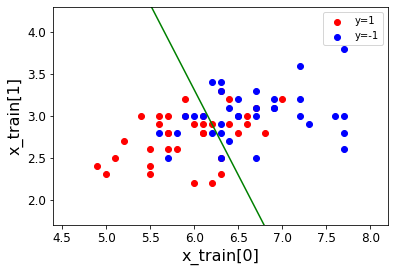

In [99]:
import matplotlib.pyplot as plt

xx, yy = lsvm.get_xxyy((np.round(x_train[:, 0].min(), 2), np.round(x_train[:, 0].max(), 2)))
plt.xlabel('x_train[0]', size=16)
plt.ylabel('x_train[1]', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
red = np.where(y_train == 1)
blue = np.where(y_train == -1)
plt.scatter(x_train[red][:, 0], x_train[red][:, 1], c='red', label='y=1')
plt.scatter(x_train[blue][:, 0], x_train[blue][:, 1], c='blue', label='y=-1')
plt.legend()
plt.xlim(np.round(x_train[:, 0].min(), 2) - 0.5, np.round(x_train[:, 0].max(), 2) + 0.5)
plt.ylim(np.round(x_train[:, 1].min(), 2) - 0.5, np.round(x_train[:, 1].max(), 2) + 0.5)
plt.plot(xx, yy, c='green')

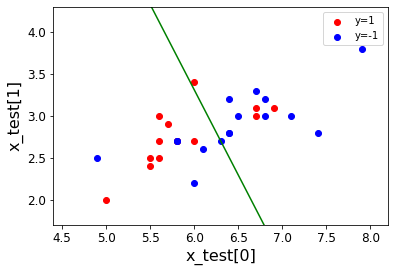

In [100]:
import matplotlib.pyplot as plt

xx, yy = lsvm.get_xxyy((int(np.floor(x_train[:, 0].min())), int(np.ceil(x_train[:, 0].max()))))
plt.xlabel('x_test[0]', size=16)
plt.ylabel('x_test[1]', size=16)
plt.xticks(size=12)
plt.yticks(size=12)
red = np.where(y_test == 1)
blue = np.where(y_test == -1)
plt.scatter(x_test[red][:, 0], x_test[red][:, 1], c='red', label='y=1')
plt.scatter(x_test[blue][:, 0], x_test[blue][:, 1], c='blue', label='y=-1')
plt.legend()
plt.xlim(np.round(x_train[:, 0].min(), 2) - 0.5, np.round(x_train[:, 0].max(), 2) + 0.5)
plt.ylim(np.round(x_train[:, 1].min(), 2) - 0.5, np.round(x_train[:, 1].max(), 2) + 0.5)
plt.plot(xx, yy, c='green')

In [103]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(max_iter=100000, C=5)
lsvc.fit(x_train, y_train)
print(lsvc.score(x_train, y_train))
print(lsvc.score(x_test, y_test))

0.7142857142857143
0.6666666666666666
